In [1]:
# Imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import datasets, models, transforms

from torch import nn
import torch.nn.functional as F


import numpy as np
import pandas as pd
from PIL import Image
import os

In [2]:
class FFClassifier(nn.Module):

    def __init__(self, in_features, hidden_features, 
                       out_features, drop_prob=0.1):
        super().__init__()

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x


def load_checkpoint(filename):
    
    model = models.vgg16(pretrained=False)

    for param in model.parameters():
        param.requires_grad = False
    n_inputs = model.classifier[6].in_features
    last_layer = nn.Linear(n_inputs,102)
    model.classifier[6] = last_layer
    
    if os.path.isfile(filename):
        print("=> loading model '{}'".format(filename))
        model.load_state_dict(torch.load(filename))
        print("=> loaded model from '{}'".format(filename))
    else:
        print("=> no model found at '{}'".format(filename))

    return model

In [3]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
model = load_checkpoint('./models/model_flower_vgg.pt')

=> loading model './models/model_flower_vgg.pt'
=> loaded model from './models/model_flower_vgg.pt'


In [4]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [6]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

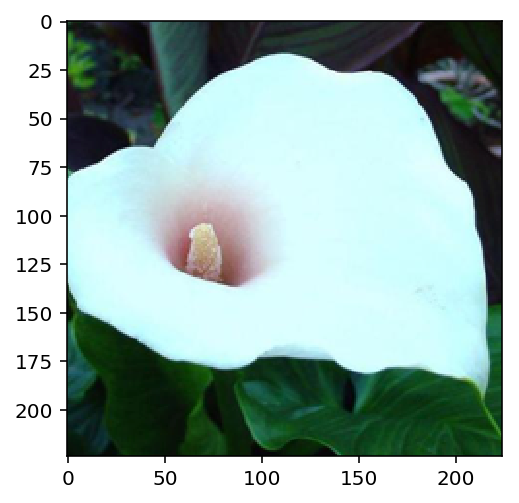

In [7]:
image_path = './flower_data/predict/image_04907.jpg'
img = process_image(image_path)
imshow(img)

In [8]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [9]:
cat_to_name

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',

In [18]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
      
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    print(top_probs)
    print(top_labs)
    
    # Convert indices to classes
    top_flowers = [cat_to_name[str(lab+1)] for lab in top_labs]
    return top_probs, top_labs, top_flowers

In [19]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)

    
    img = process_image(image_path)
    imshow(img, ax, title = 1);
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

[2691.22119140625, 0.2842235565185547, 0.19317452609539032, 0.15737579762935638, 0.13034121692180634]
[15, 36, 42, 40, 81]


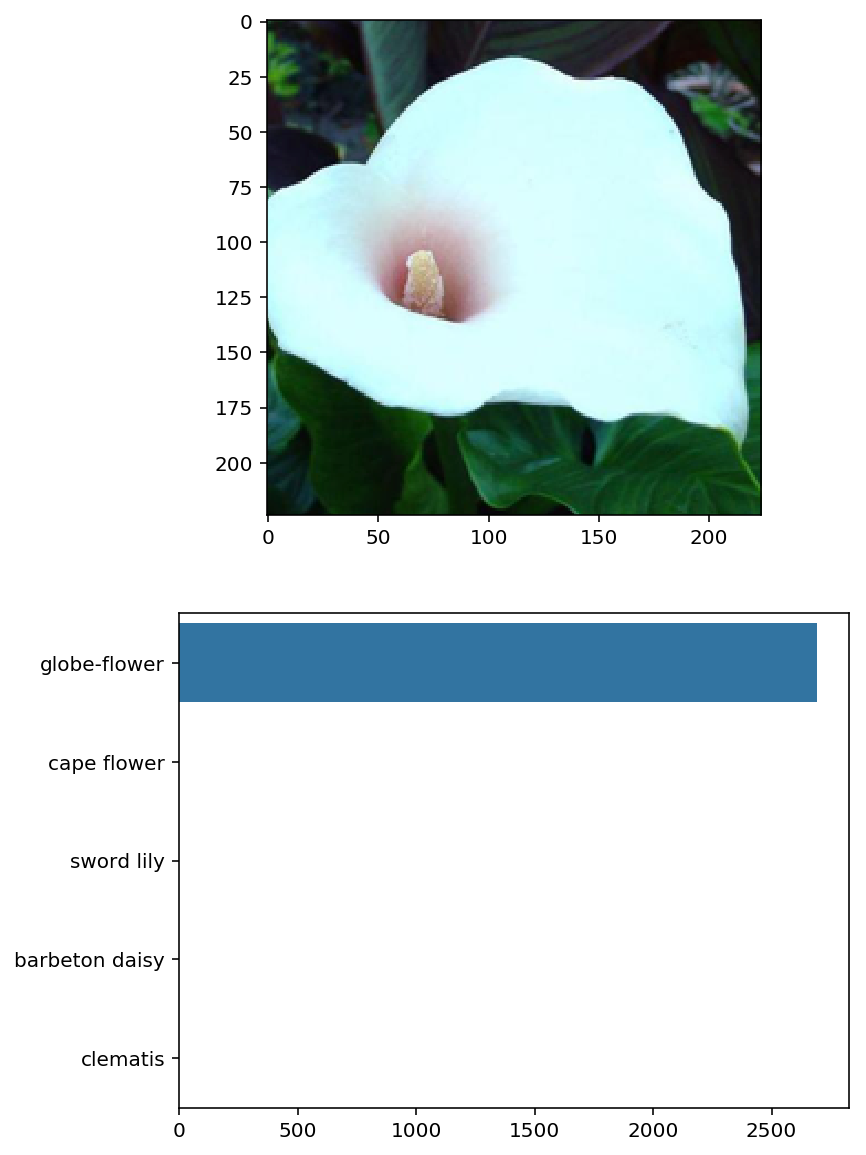

In [20]:
image_path = './flower_data/predict/image_04907.jpg'

plot_solution(image_path, model)

[603.8400268554688, 312.6798095703125, 85.16077423095703, 11.625240325927734, 1.1620848178863525]
[1, 8, 11, 24, 2]


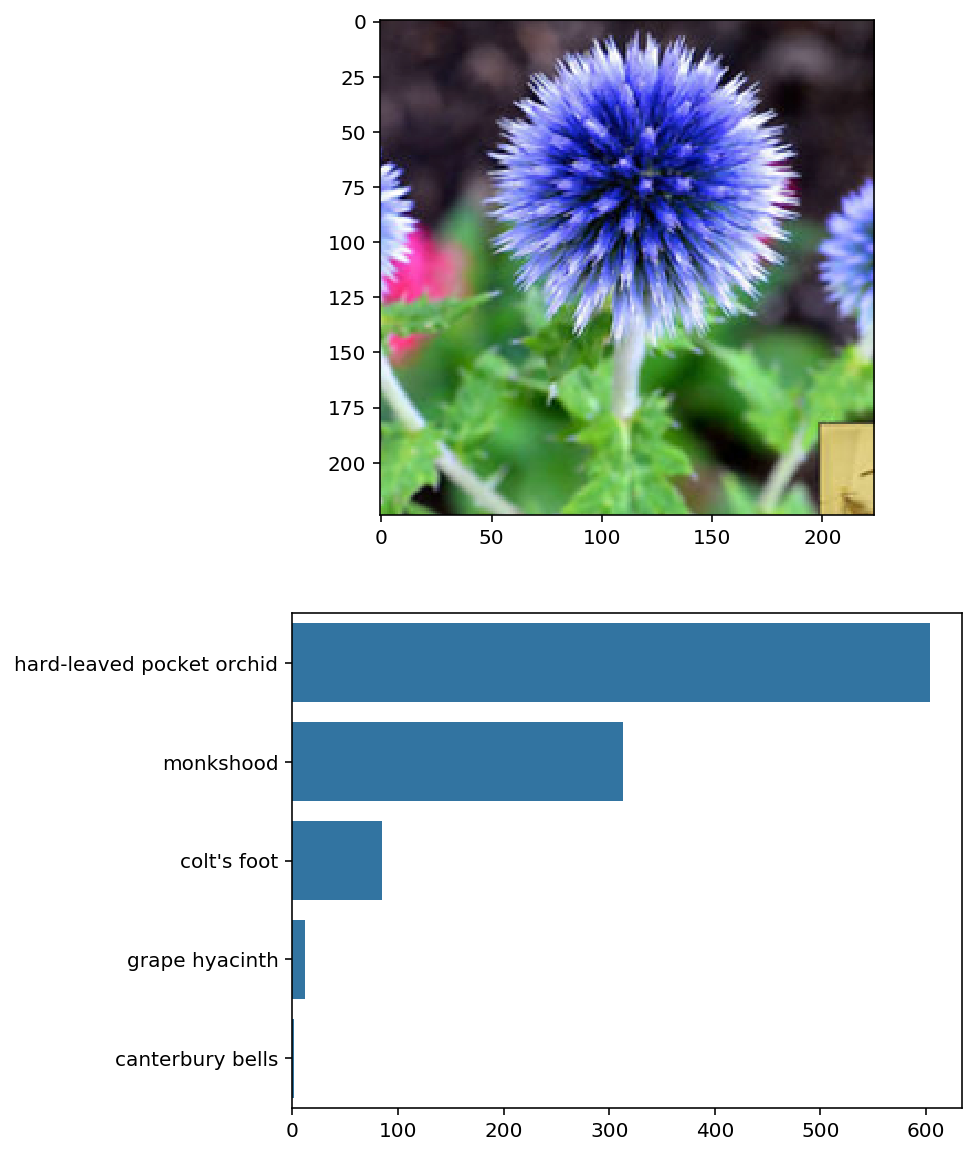

In [21]:
image_path = './flower_data/predict/1. s-l300.jpg'

plot_solution(image_path, model)

[41.373172760009766, 0.3255895972251892, 0.09233219921588898, 0.05725051462650299, 0.052019111812114716]
[54, 47, 57, 71, 38]


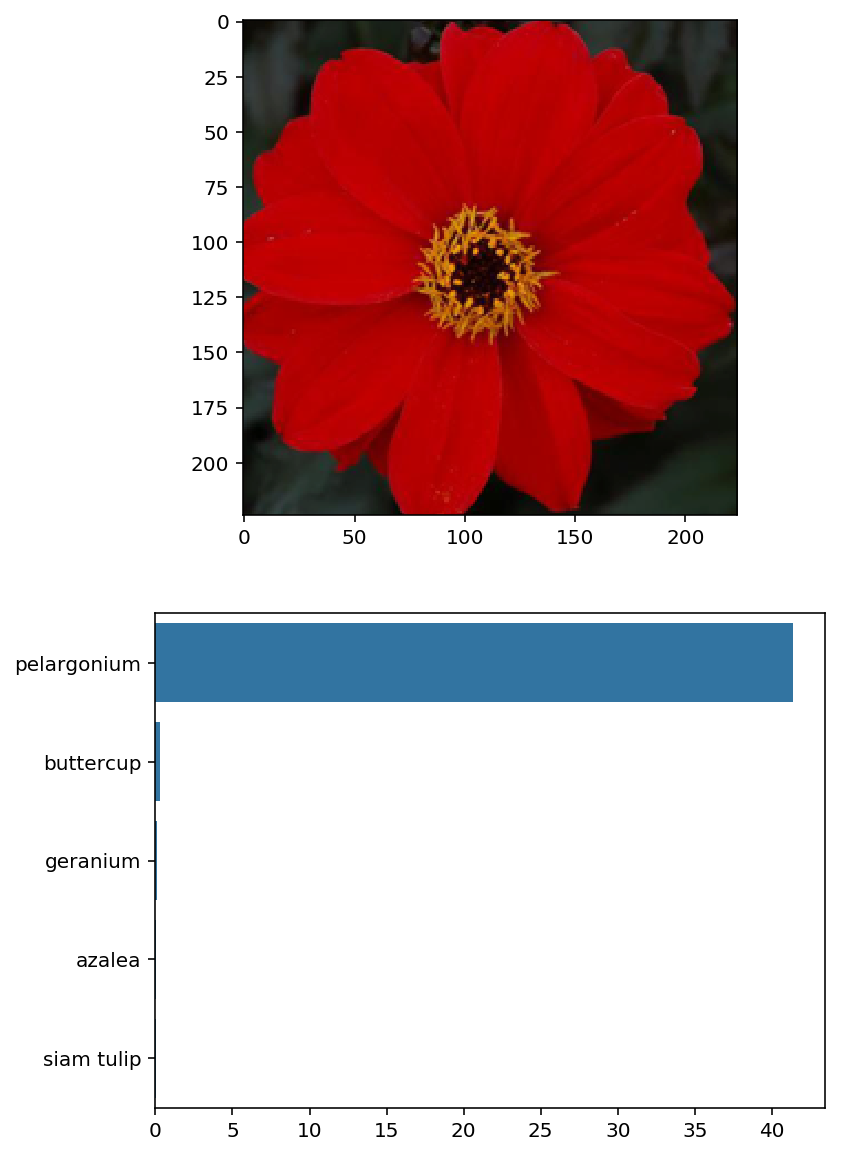

In [22]:
image_path = './flower_data/predict/image_02858.jpg'

plot_solution(image_path, model)

[5.1266045570373535, 2.3280816078186035, 0.5200729966163635, 0.3187236487865448, 0.20439322292804718]
[0, 51, 30, 42, 50]


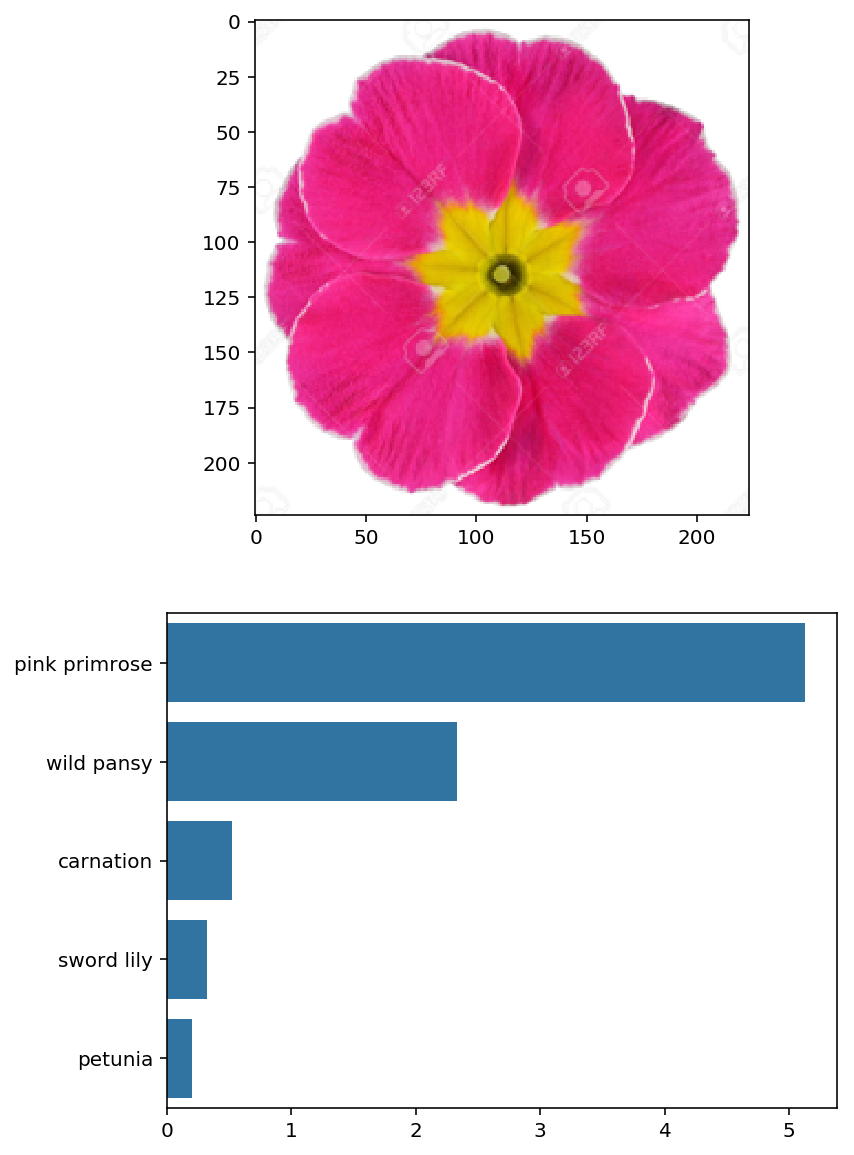

In [23]:
image_path = './flower_data/predict/primula-flower.jpg'

plot_solution(image_path, model)


[0.6642214059829712, 0.14026950299739838, 0.10732662677764893, 0.085840605199337, 0.052552785724401474]
[0, 76, 90, 73, 83]


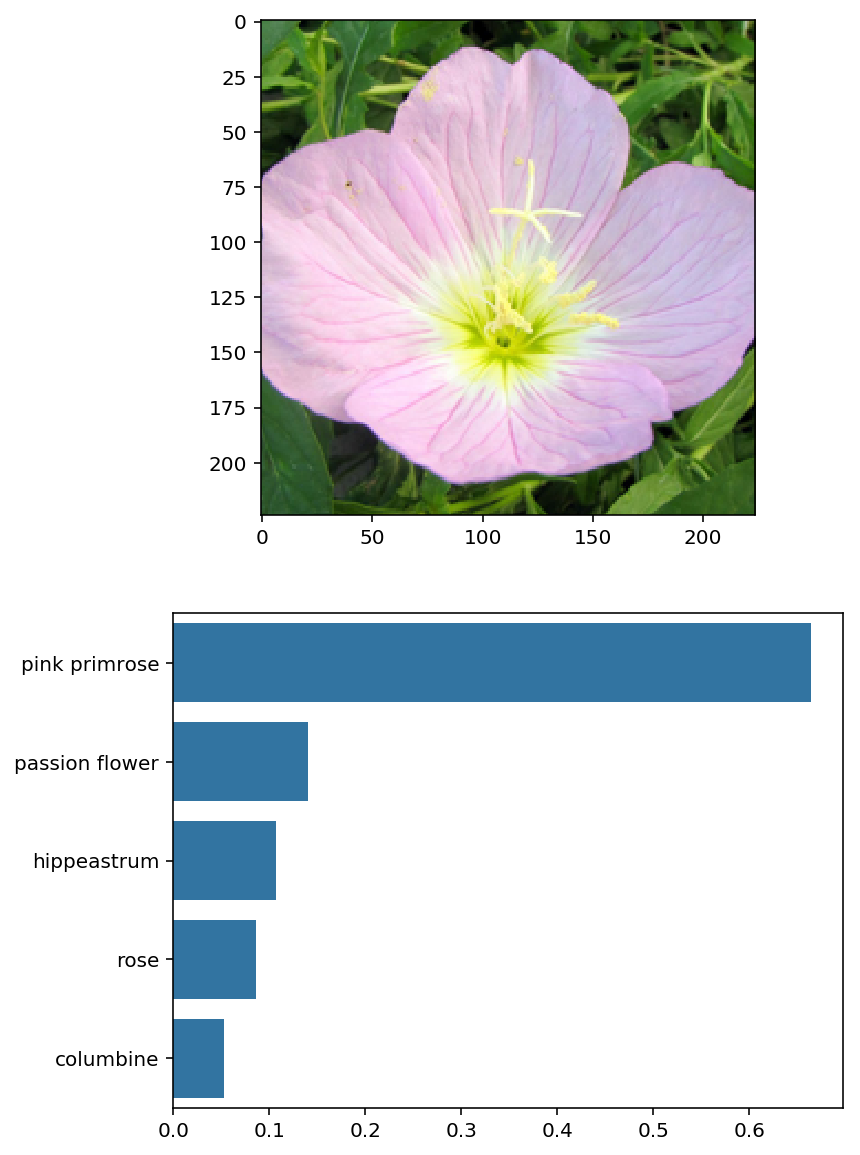

In [24]:
image_path = './flower_data/predict/showy_primrose.jpg'

plot_solution(image_path, model)